In [71]:
import math
import matplotlib.pyplot as plt
import numpy as np

y_z = 0.07
f_b = 0.2
R = 0.46
Omega_L0 = 0.6911
Omega_r0 = 0
Omega_m0 = 0.3089
h_0 = 0.6774
#Note the difference between h_0 here and h below 

In [72]:
a_0 = 1.0/7.0               #1.0/(1+z), where z = 6
M_vir_0 = 10**11           #the halo mass at z = 6
M_gas_0 = f_b*(10**11)      #the gas mass at z = 6
M_tot_0 = M_gas_0           #the total mass at z = 6
Z_0 = 0                     #the metallicity at z = 6
S_0 = 1.0                   #the SFE at z = 0
S_index = -1.5              #the parameter in S(z)
B_0 = 1.0                   #the mass loading factor at z = 0
B_index = 1                 #the parameter in B(z)

#The code in the following block does not need to be run, the final data has been saved.

In [57]:
#define lookback time[Gyr] using the second method
n_integral = 3000              
def f(z):
    s = 1/((1+z)*math.sqrt(((1+z)**2)*(1+Omega_m0*z)-z*(2+z)*Omega_L0))
    return s
def lookbacktime(z):
    h = (z-0)/(2.0000000*n_integral)
    F0 = f(0)+f(z)
    F1 = 0
    F2 = 0
    for j in range(1,2*n_integral):
        x = j*h
        if j%2 == 0:
            F2 = F2+f(x)
        else:
            F1 = F1+f(x)
    return ((h/3)*(F0+(2*F2)+(4*F1)))*9.78*(10**9)/h_0/(10**9)#[Gyr]

#get an array of Z
Redshift_raw = dict(np.load('/huawei/osv1/chenyaoxin/workspace/Data/SnapRedshift.npz'))
#data from TNG300
z_values_raw = np.append(np.delete(np.append(Redshift_raw['Redshift'][13:99],[0])[::-1],[86]),[6.0])
t_values_raw = np.array([lookbacktime(6)-lookbacktime(z) for z in z_values_raw])
delta_t=10**(-5)

flag = 0
z_values = np.array([0])
while flag <= (z_values_raw.shape[0]-2):
    dim = z_values.shape[0]
    z_values = np.delete(z_values, [dim-1])
    n = int((abs(t_values_raw[flag]-t_values_raw[flag+1]))/delta_t)
    z_values = np.append(z_values, np.linspace(z_values_raw[flag],z_values_raw[flag+1],n))
    flag += 1

t_values = np.array([lookbacktime(6)-lookbacktime(z) for z in z_values])
np.savez('/huawei/osv1/chenyaoxin/workspace/Data/redshift-evolution_time10**(-5).npz', redshift = z_values, evolution_time = t_values)

KeyboardInterrupt: 

#Draw the pdf of delta_t

(array([  120.,   344.,  1193.,  3716., 17647., 13703.,  2567.,   872.,
          307.,   104.]),
 array([0.00029212, 0.00029728, 0.00030244, 0.00030759, 0.00031275,
        0.0003179 , 0.00032306, 0.00032822, 0.00033337, 0.00033853,
        0.00034368]),
 <BarContainer object of 10 artists>)

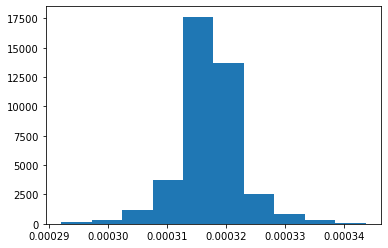

In [41]:
Arr = dict(np.load('/huawei/osv1/chenyaoxin/workspace/Data/redshift-evolution_time10**(-3.5).npz'))
t_values = Arr['evolution_time']
flag = 0
delta_t_true_values = np.array([])
while flag <= (t_values.shape[0]-2):
    delta_t_true_values = np.append(delta_t_true_values, abs(t_values[flag]-t_values[flag+1]))
    flag += 1

plt.hist(delta_t_true_values)

#Get arrays of redshift and evolution time

In [73]:
#get an array of z and t
Arr = dict(np.load('/huawei/osv1/chenyaoxin/workspace/Data/redshift-evolution_time10**(-4).npz'))
#data from the code of upper block
z_values = Arr['redshift'][::-1]
t_values = Arr['evolution_time'][::-1]
num = z_values.shape[0]

#Define the functions and get arrays of SFE, mass loading factor and the halo mass

In [74]:
#define S(z)
def S(z):
    return S_0*((1+z)**S_index)
#define B(z)
def B(z):
    return B_0*((1+z)**B_index)
#define M_vir(z)
def M_vir(z):
    return M_vir_0*math.exp(0-8.2*a_0/13.0+8.2/(13.0*(1+z)))
#get an array of S
S_values=[S(z) for z in z_values]
#get an array of B
B_values=[B(z) for z in z_values]
#get an array of M_vir
M_vir_values=[M_vir(z) for z in z_values]

### calculate delta_M_vir

In [75]:
delta_M_vir_values = np.array([])
flag = 0
while flag <= num-2:
    delta_M_vir_values = np.append(delta_M_vir_values, M_vir_values[flag+1]-M_vir_values[flag])
    flag += 1

### calculate delta_M_infall 

In [76]:
delta_M_infall_values = np.array([])
flag = 0
while flag <= num-2:
    result = 0.01*delta_M_vir_values[flag]
    delta_M_infall_values = np.append(delta_M_infall_values, result)
    flag +=1

### calculate M_gas

In [77]:
M_gas_values = np.array([M_gas_0])
flag = 0
while flag <= num-2:
    result1 = 0-(1-R+B_values[flag])*S_values[flag]*M_gas_values[flag]*(t_values[flag+1]-t_values[flag])+delta_M_infall_values[flag]
    result2 = M_gas_values[flag]+result1
    M_gas_values = np.append(M_gas_values, result2)
    flag +=1

### calculate M_tot

In [78]:
M_tot_values = np.array([M_tot_0])
flag = 0
while flag <= num-2:
    result1 = delta_M_infall_values[flag]-B_values[flag]*S_values[flag]*M_gas_values[flag]*(t_values[flag+1]-t_values[flag])
    result2 = M_tot_values[flag]+result1
    M_tot_values = np.append(M_tot_values,result2)
    flag += 1


### calculate M_star

In [79]:
M_star_values = np.array([])
flag = 0
while flag <= num-1:
    M_star_values = np.append(M_star_values, M_tot_values[flag]-M_gas_values[flag])
    flag += 1

### calculate SFR

In [80]:
SFR_values = np.array([])
flag = 0
while flag <= num-1:
    SFR_values = np.append(SFR_values, S_values[flag]*M_gas_values[flag]/(10**9))
    flag += 1

### calculate metallicity Z

In [81]:
Z_values = np.array([Z_0])
flag = 0
while flag <= num-2:
    result1 = y_z*(1-R)*S_values[flag]*(t_values[flag+1]-t_values[flag])-(Z_values[flag]*delta_M_infall_values[flag]/M_gas_values[flag])
    result2 = Z_values[flag]+result1
    Z_values = np.append(Z_values, result2)
    flag += 1
    

### figure

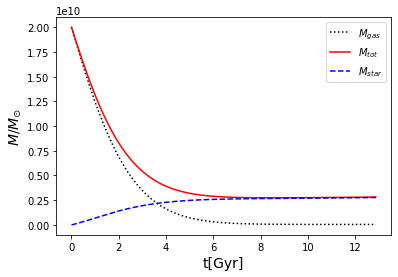

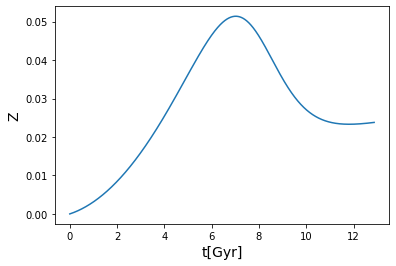

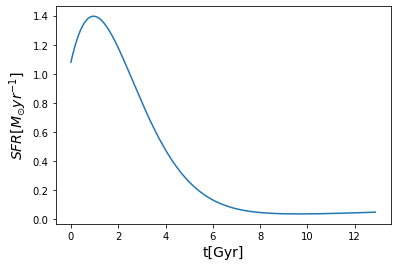

In [82]:
judge_number = num-1
#M
plt.figure('The first figure')
plt.plot(t_values[0:judge_number],M_gas_values[0:judge_number],color="black",linestyle=":",label='${M_{gas}}$')
plt.plot(t_values[0:judge_number],M_tot_values[0:judge_number],color="red",linestyle="-",label='${M_{tot}}$')
plt.plot(t_values[0:judge_number],M_star_values[0:judge_number],color="blue",linestyle="--",label='${M_{star}}$')
plt.xlabel("t[Gyr]",fontsize=14)
plt.ylabel("${M}$/${M_{\odot}}$",fontsize=14)
plt.legend(loc=1)
plt.savefig('/huawei/osv1/chenyaoxin/workspace/Figure/working-from t=0/M')

#Z
plt.figure('The second figure')
plt.plot(t_values[0:judge_number],Z_values[0:judge_number])
plt.xlabel("t[Gyr]",fontsize=14)
plt.ylabel("Z",fontsize=14)
plt.savefig('/huawei/osv1/chenyaoxin/workspace/Figure/working-from t=0/Z')

#SFR
plt.figure('The third figure')
plt.plot(t_values[0:judge_number],SFR_values[0:judge_number])
plt.xlabel("t[Gyr]",fontsize=14)
plt.ylabel("${SFR}$${[M_{\odot}yr^{-1}]}$",fontsize=14)
plt.savefig('/huawei/osv1/chenyaoxin/workspace/Figure/working-from t=0/SFR') 

### Print

In [83]:
print('M_vir(z=0):')
print(M_vir_values[judge_number])
print('M_gas(z=0):')
print(M_gas_values[judge_number])
print('M_tot(z=0):')
print(M_tot_values[judge_number])
print('M_star(z=0):')
print(M_star_values[judge_number])
print('Z(z=0):')
print(Z_values[judge_number])


M_vir(z=0):
171713866836.27176
M_gas(z=0):
48194730.20489551
M_tot(z=0):
2820119015.6858306
M_star(z=0):
2771924285.480935
Z(z=0):
0.02379702366265354
